Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 5296067.90it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 157118.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1456818.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1758402.14it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



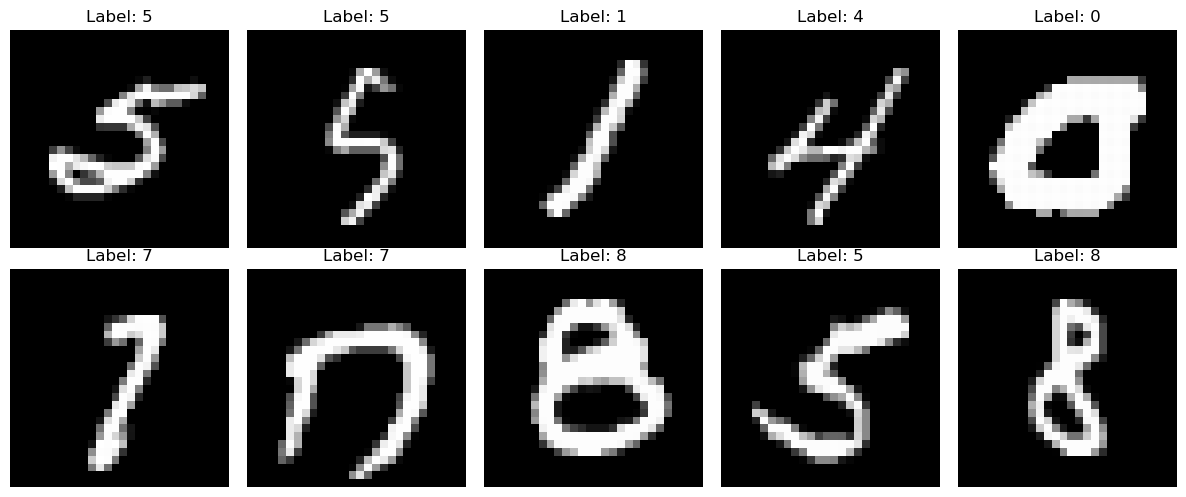

Dataset size: 60000
Testset size: 10000
Image shape: torch.Size([1, 28, 28])


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
train_data = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_data = torchvision.datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

# Display 10 random samples
for idx in range(10):
    # Get a random sample
    rand_idx = np.random.randint(0, len(train_data))
    image, label = train_data[rand_idx]

    # Convert tensor to numpy array and reshape
    image = image.squeeze().numpy()

    # Display the image
    axes[idx].imshow(image, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'Label: {label}')

plt.tight_layout()
plt.show()

# Print some basic information about the dataset
print(f"Dataset size: {len(train_data)}")
print(f"Testset size: {len(test_data)}")
print(f"Image shape: {train_data[0][0].shape}")

In [2]:
# Load MNIST dataset
def init_indices(train: bool):
    train_data = torchvision.datasets.MNIST(
        './data',
        train=train,
        download=False,
        transform=torchvision.transforms.ToTensor(),
    )

    digit_indices = {i: [] for i in range(10)}
    for idx in range(len(train_data)):
        image, label = train_data[idx]
        digit_indices[label].append(image)
    return digit_indices

In [3]:
from torch.utils.data import Dataset


class DigitDataset(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def add_item(self, image, label):
        self.images.append(image)
        self.labels.append(label)

    def shuffle(self):
        permutation = np.random.permutation(len(self.labels))
        new_images = []
        new_labels = []
        for p in permutation:
            new_images.append(self.images[p])
            new_labels.append(self.labels[p])
        self.images = new_images
        self.labels = new_labels

    def save(self, path):
        """Save dataset in compressed format"""
        torch.save({
            'images': self.images,
            'labels': self.labels
        }, path, _use_new_zipfile_serialization=True)
    
    @classmethod
    def load(cls, path):
        """Load dataset from compressed file"""
        data = torch.load(path)
        return cls(data['images'], data['labels'])

In [4]:
from collections import Counter

def plot_distributions(ax, sampled_dataset):
    digits = range(10)
    labels2 = [label for _, label in sampled_dataset]
    counts2 = Counter(labels2)
    frequencies2 = [counts2.get(d, 0) for d in digits]
    
    ax.bar(digits, frequencies2)
    ax.set_title('Sampled Distribution')
    ax.set_xlabel('Digit')
    ax.set_ylabel('Frequency')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

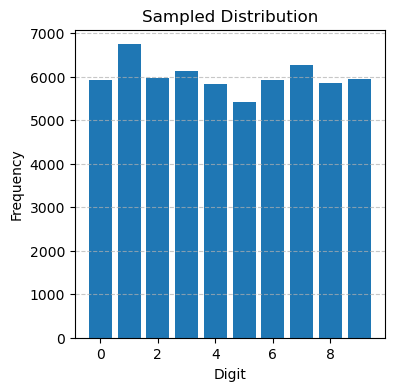

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_distributions(ax, train_data)
plt.show()

# Scenario 1

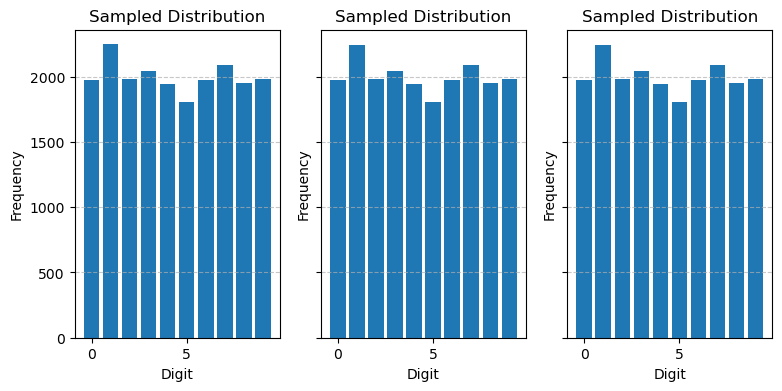

In [9]:
indices = init_indices(True)
clients = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        clients[i % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(clients):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

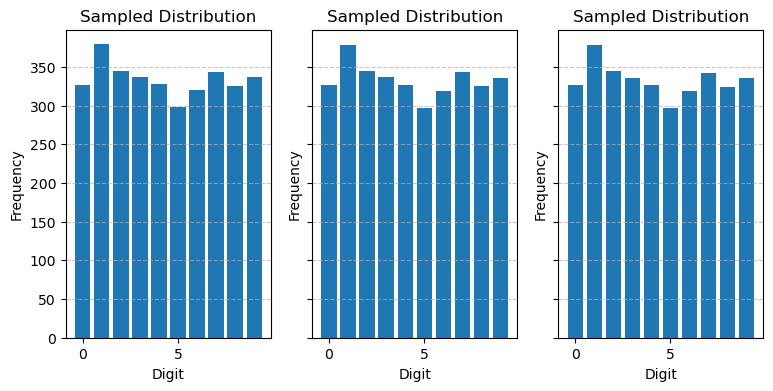

In [10]:
indices = init_indices(False)
test_sets = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        test_sets[i % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(test_sets):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

In [11]:
import os

data_dir = 'scenario1'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for i in range(3):
    clients[i].save(os.path.join(data_dir, f'site-{i + 1}.pt'))
    test_sets[i].save(os.path.join(data_dir, f'site-{i + 1}_test.pt'))

# Scenario 2

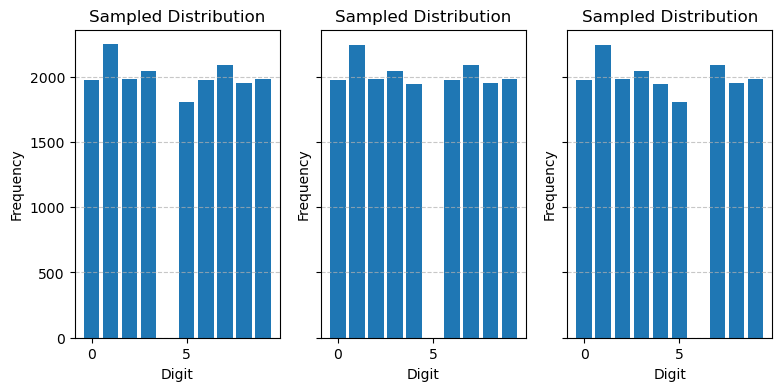

In [12]:
indices = init_indices(True)
clients = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        if d == 4 and i % 3 == 0:
            continue
        if d == 5 and i % 3 == 1:
            continue
        if d == 6 and i % 3 == 2:
            continue
        clients[i % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(clients):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

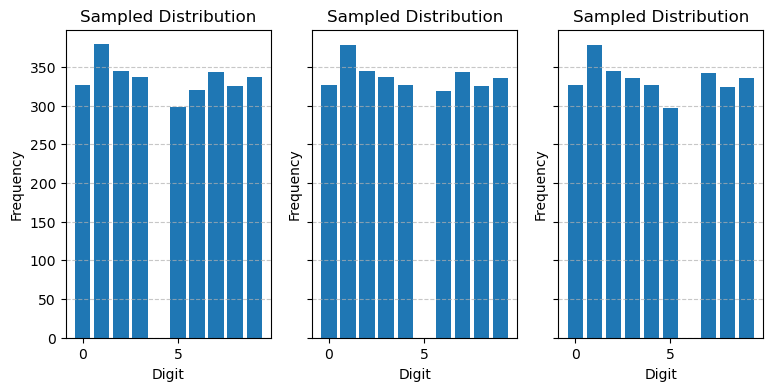

In [13]:
indices = init_indices(False)
test_sets = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        if d == 4 and i % 3 == 0:
            continue
        if d == 5 and i % 3 == 1:
            continue
        if d == 6 and i % 3 == 2:
            continue
        test_sets[i % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(test_sets):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

In [14]:
import os

data_dir = 'scenario2'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for i in range(3):
    clients[i].save(os.path.join(data_dir, f'site-{i + 1}.pt'))
    test_sets[i].save(os.path.join(data_dir, f'site-{i + 1}_test.pt'))

# Scenario 3

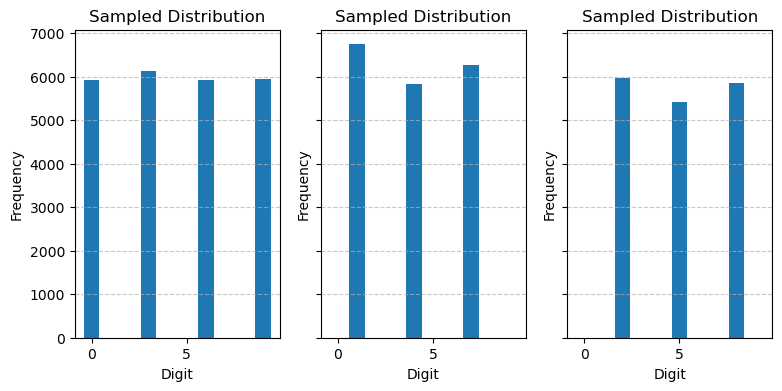

In [15]:
indices = init_indices(True)
clients = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        clients[d % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(clients):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

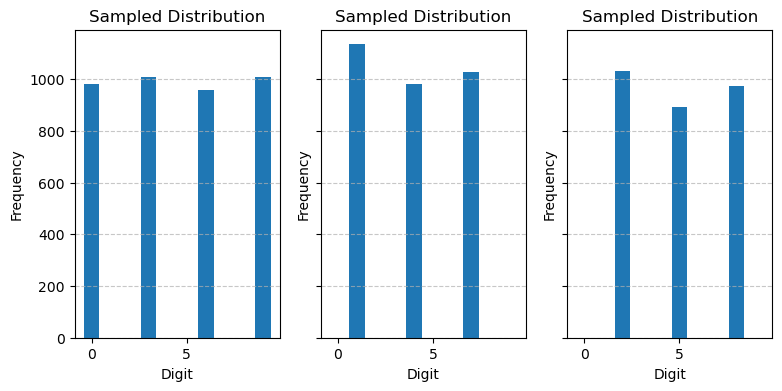

In [16]:
indices = init_indices(False)
test_sets = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in enumerate(indices[d]):
        test_sets[d % 3].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(test_sets):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

In [17]:
import os

data_dir = 'scenario3'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for i in range(3):
    clients[i].save(os.path.join(data_dir, f'site-{i + 1}.pt'))
    test_sets[i].save(os.path.join(data_dir, f'site-{i + 1}_test.pt'))

# Scenario 4

In [8]:
train_data = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=False,
    transform=torchvision.transforms.ToTensor(),
)
test_data = torchvision.datasets.MNIST(
    './data',
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor(),
)

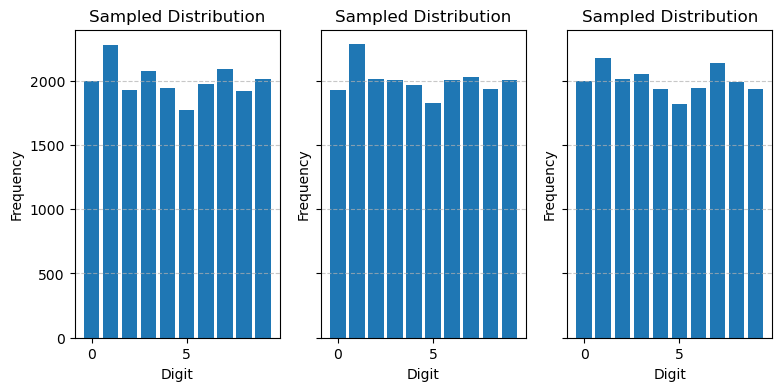

In [9]:
clients = [DigitDataset(), DigitDataset(), DigitDataset()]

for i, (image, label) in enumerate(train_data):
    if i < len(train_data) // 3:
        clients[0].add_item(image, label)
    elif i < 2 * len(train_data) // 3:
        clients[1].add_item(image, label)
    else:
        clients[2].add_item(torch.rand(image.size()), label)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(clients):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

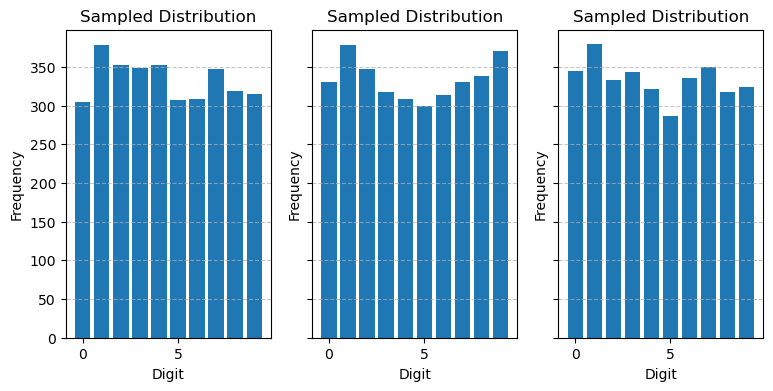

In [12]:
test_sets = [DigitDataset(), DigitDataset(), DigitDataset()]

for i, (image, label) in enumerate(test_data):
    if i < len(test_data) // 3:
        test_sets[0].add_item(image, label)
    elif i < 2 * len(test_data) // 3:
        test_sets[1].add_item(image, label)
    else:
        test_sets[2].add_item(torch.rand(image.size()), label)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(test_sets):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

In [13]:
import os

data_dir = 'scenario4'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for i in range(3):
    clients[i].save(os.path.join(data_dir, f'site-{i + 1}.pt'))
    test_sets[i].save(os.path.join(data_dir, f'site-{i + 1}_test.pt'))

# Global Data

In [27]:
global_train = DigitDataset()
global_test = DigitDataset()

for image, label in train_data:
    global_train.add_item(image, label)

for image, label in test_data:
    global_test.add_item(image, label)

global_train.shuffle()
global_test.shuffle()

data_dir = 'global'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

global_train.save(os.path.join(data_dir, f'global.pt'))
global_test.save(os.path.join(data_dir, f'global_test.pt'))

# Upload to S3

In [14]:
import boto3

s3 = boto3.client('s3')

data_bucket_name = 'flare-data-bucket-202533536016'

In [15]:
for i in range(4):
    for j in range(3):
        s3.upload_file(f'scenario{i + 1}/site-{j + 1}.pt', data_bucket_name, f'scenario{i + 1}/site-{j + 1}.pt')
        s3.upload_file(f'scenario{i + 1}/site-{j + 1}_test.pt', data_bucket_name, f'scenario{i + 1}/site-{j + 1}_test.pt')

In [28]:
s3.upload_file(f'global/global.pt', data_bucket_name, f'global.pt')
s3.upload_file(f'global/global_test.pt', data_bucket_name, f'global_test.pt')